## Pipeline for Team4

This notebook contains the following items:  
1)Baseline pipeline - Tokenizer -> HashingTF -> LinearRegression; with best case RMSE on test of 0.5356 on kaggle.  
2)Pipeline1 - Stemming -> Tokenizer -> StopWordsRemover -> TF IDF -> Match words, Cosine and Jaccard Similarity -> RandomForest; with best case RMSE on test of 0.50754 on kaggle.  
3)Pipeline2 - Stemming -> Tokenizer -> StopWordsRemover -> Word2Vec -> Cosine Similarity, Match Words and Jaccard Similarity -> RandomForest; with best case RMSE on test of 0.50651 on kaggle.


## Importing libraries and setting the spark Context

In [2]:
import csv
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession

# Intializing the context
spark = SparkSession\
        .builder\
        .appName("FinalPJ10")\
        .getOrCreate()
sc = spark.sparkContext
sql_sc = SQLContext(sc)

## BaseLine Pipeline: Developing the minimum viable pipeline

Created a pipeline in python that contains the minimum number of components, consisting of a tokenizer and hashing TF transformer linked to a linear regression estimator. 

## Best Result with BaseLine Pipeline 
## RMSE on test was 0.5356

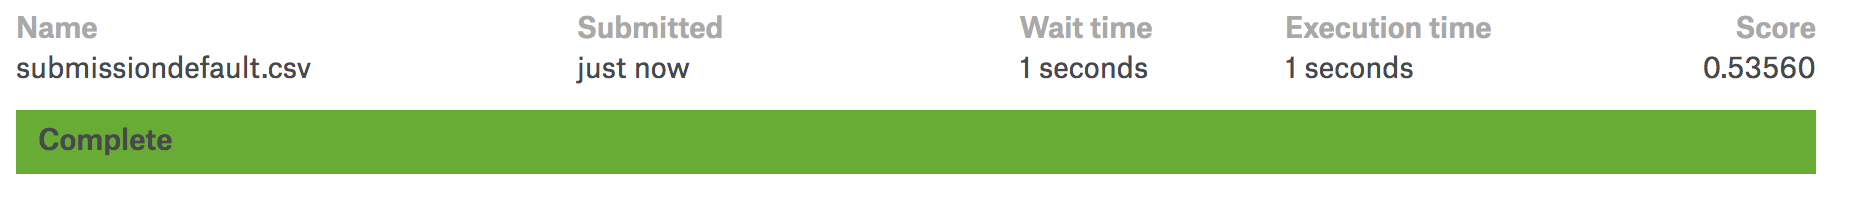

In [50]:
from IPython.display import Image

#result for linear regression
Image(filename='Downloads/task15/DataSet/linearRegression.png')

## Previous Iteration results with our BaseLine Pipeline


Tweaked the regParam of Linear Regression to 0.00001. Although RMSE on train proved to be 0.437, due to several values being wrongly predicted out of bounds from 1-3 range, the resultant RMSE on test from kaggle proved to be higher.

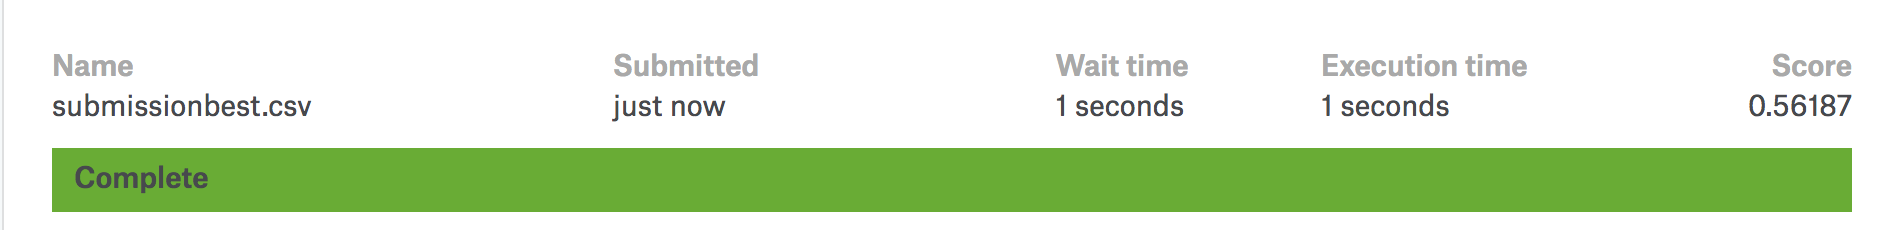

In [55]:
from IPython.display import Image

#result for linear regression
Image(filename='Downloads/task15/DataSet/linearRegression2.png')

## Bring in the train data


In [43]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType,StringType,IntegerType
from pyspark.sql.functions import lit
from pyspark.sql.functions import col, when

#read data from file
dataSchema = StructType([
    StructField("id", IntegerType()),
    StructField("pid", IntegerType()),
    StructField("title", StringType()),
    StructField("term", StringType()),
    StructField("label", DoubleType())
   
])



trainbase=sql_sc.read.format("com.databricks.spark.csv").option("header","true")\
   .schema(dataSchema).load("Desktop/task15/data/train.csv")
trainbase.show()

+---+------+--------------------+--------------------+-----+
| id|   pid|               title|                term|label|
+---+------+--------------------+--------------------+-----+
|  2|100001|Simpson Strong-Ti...|       angle bracket|  3.0|
|  3|100001|Simpson Strong-Ti...|           l bracket|  2.5|
|  9|100002|BEHR Premium Text...|           deck over|  3.0|
| 16|100005|Delta Vero 1-Hand...|    rain shower head| 2.33|
| 17|100005|Delta Vero 1-Hand...|  shower only faucet| 2.67|
| 18|100006|Whirlpool 1.9 cu....|      convection otr|  3.0|
| 20|100006|Whirlpool 1.9 cu....|microwave over stove| 2.67|
| 21|100006|Whirlpool 1.9 cu....|          microwaves|  3.0|
| 23|100007|Lithonia Lighting...|     emergency light| 2.67|
| 27|100009|House of Fara 3/4...|             mdf 3/4|  3.0|
| 34|100010|Valley View Indus...|        steele stake| 2.67|
| 35|100011|Toro Personal Pac...|briggs and stratt...|  3.0|
| 37|100011|Toro Personal Pac...|            gas mowe|  3.0|
| 38|100011|Toro Persona

## Bring in the test data


In [44]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType,StringType,IntegerType
from pyspark.sql.functions import lit
from pyspark.sql.functions import col, when

#read data from file
testdataSchema = StructType([
    StructField("id", IntegerType()),
    StructField("pid", IntegerType()),
    StructField("title", StringType()),
    StructField("term", StringType())
    
])



testbase=sql_sc.read.format("com.databricks.spark.csv").option("header","true")\
   .schema(testdataSchema).load("Desktop/task15/data/test.csv")
testbase.show()

+---+------+--------------------+--------------------+
| id|   pid|               title|                term|
+---+------+--------------------+--------------------+
|  1|100001|Simpson Strong-Ti...|   90 degree bracket|
|  4|100001|Simpson Strong-Ti...|    metal l brackets|
|  5|100001|Simpson Strong-Ti...|    simpson sku able|
|  6|100001|Simpson Strong-Ti...|simpson strong  ties|
|  7|100001|Simpson Strong-Ti...|simpson strong ti...|
|  8|100001|Simpson Strong-Ti...|     wood connectors|
| 10|100003|STERLING Ensemble...| bath and shower kit|
| 11|100003|STERLING Ensemble...|      bath drain kit|
| 12|100003|STERLING Ensemble...|one piece tub shower|
| 13|100004|Grape Solar 265-W...|         solar panel|
| 14|100005|Delta Vero 1-Hand...|1 handle shower d...|
| 15|100005|Delta Vero 1-Hand...|delta ashland sho...|
| 19|100006|Whirlpool 1.9 cu....|       cooking stove|
| 22|100006|Whirlpool 1.9 cu....|microwaves over r...|
| 24|100008|Teks #10 1-1/2 in...| self tapping screws|
| 25|10000

## Define the Tokenizer transformer


In [45]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import HashingTF, Tokenizer


# Configure an ML pipeline, which consists of one stages: tokenizer, hashingTF, and lr.
tokenizerBase = Tokenizer(inputCol="term", outputCol="words")
train1base = tokenizerBase.transform(trainbase)
train1base.show()

#test = tokenizer.transform(test)
#test.show()



+---+------+--------------------+--------------------+-----+--------------------+
| id|   pid|               title|                term|label|               words|
+---+------+--------------------+--------------------+-----+--------------------+
|  2|100001|Simpson Strong-Ti...|       angle bracket|  3.0|    [angle, bracket]|
|  3|100001|Simpson Strong-Ti...|           l bracket|  2.5|        [l, bracket]|
|  9|100002|BEHR Premium Text...|           deck over|  3.0|        [deck, over]|
| 16|100005|Delta Vero 1-Hand...|    rain shower head| 2.33|[rain, shower, head]|
| 17|100005|Delta Vero 1-Hand...|  shower only faucet| 2.67|[shower, only, fa...|
| 18|100006|Whirlpool 1.9 cu....|      convection otr|  3.0|   [convection, otr]|
| 20|100006|Whirlpool 1.9 cu....|microwave over stove| 2.67|[microwave, over,...|
| 21|100006|Whirlpool 1.9 cu....|          microwaves|  3.0|        [microwaves]|
| 23|100007|Lithonia Lighting...|     emergency light| 2.67|  [emergency, light]|
| 27|100009|Hous

## Defining the HashingTF Transfomer

In [47]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import HashingTF, Tokenizer


# Configure an ML pipeline, which consists of one stages: tokenizer, hashingTF, and lr.
hashingTFbase = HashingTF(inputCol=tokenizerBase.getOutputCol(), outputCol="features")
train1base = hashingTFbase.transform(train1base)
train1base.show()


#test = hashingTF.transform(test)
#test.show()



+---+------+--------------------+--------------------+-----+--------------------+--------------------+
| id|   pid|               title|                term|label|               words|            features|
+---+------+--------------------+--------------------+-----+--------------------+--------------------+
|  2|100001|Simpson Strong-Ti...|       angle bracket|  3.0|    [angle, bracket]|(262144,[54375,22...|
|  3|100001|Simpson Strong-Ti...|           l bracket|  2.5|        [l, bracket]|(262144,[213302,2...|
|  9|100002|BEHR Premium Text...|           deck over|  3.0|        [deck, over]|(262144,[33787,17...|
| 16|100005|Delta Vero 1-Hand...|    rain shower head| 2.33|[rain, shower, head]|(262144,[101160,1...|
| 17|100005|Delta Vero 1-Hand...|  shower only faucet| 2.67|[shower, only, fa...|(262144,[102379,1...|
| 18|100006|Whirlpool 1.9 cu....|      convection otr|  3.0|   [convection, otr]|(262144,[130729,1...|
| 20|100006|Whirlpool 1.9 cu....|microwave over stove| 2.67|[microwave, o

## Defined the Linear Regression estimator and RMSE on train

Using Default parameters of the Linear Regression estimator, an RMSE of 0.533980 is obtained

In [51]:
#RMSE: 0.533980 with 0.3 as regParam
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import HashingTF, Tokenizer


# Configure an ML pipeline, which consists of one stages: tokenizer, hashingTF, and lr.
lrbase = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModelbase = lrbase.fit(train1base)
trainingSummarybase = lrModelbase.summary
print("RMSE on train: %f" % trainingSummarybase.rootMeanSquaredError) 

RMSE on train: 0.533980


## Define the pipeline
Train the pipeline on training data,  
Evaluate performance and  
Make estimations on test data  

In [49]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import HashingTF, Tokenizer

# Configure an ML pipeline, which consists of one stages: tokenizer, hashingTF, and lr.
tokenizerbase2 = Tokenizer(inputCol="term", outputCol="words")
hashingTFbase2 = HashingTF(inputCol=tokenizerbase2.getOutputCol(), outputCol="features")
lrbase2 = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
pipelinebase = Pipeline(stages=[tokenizerbase2, hashingTFbase2, lrbase2])

# Fit the pipeline to training documents.
modelbase = pipelinebase.fit(trainbase)



# Make predictions on test documents and print columns of interest.
predictionbase = modelbase.transform(testbase)
predictionbase.show()
res = predictionbase['id','prediction']
res = res.selectExpr("id as id", "prediction as relevance")
res.show()
result = res.toPandas()
result.to_csv('Desktop/task15/data/submissiondefault.csv',index=False)


+---+------+--------------------+--------------------+--------------------+--------------------+------------------+
| id|   pid|               title|                term|               words|            features|        prediction|
+---+------+--------------------+--------------------+--------------------+--------------------+------------------+
|  1|100001|Simpson Strong-Ti...|   90 degree bracket|[90, degree, brac...|(262144,[3373,546...|2.3816337910270384|
|  4|100001|Simpson Strong-Ti...|    metal l brackets|[metal, l, brackets]|(262144,[29752,68...|2.3816337910270384|
|  5|100001|Simpson Strong-Ti...|    simpson sku able|[simpson, sku, able]|(262144,[5505,101...|2.3816337910270384|
|  6|100001|Simpson Strong-Ti...|simpson strong  ties|[simpson, strong,...|(262144,[5505,159...|2.3816337910270384|
|  7|100001|Simpson Strong-Ti...|simpson strong ti...|[simpson, strong,...|(262144,[5505,224...|2.3816337910270384|
|  8|100001|Simpson Strong-Ti...|     wood connectors|  [wood, connector

## Tweaking the parameters of the Estimator to improve RMSE on train

An RMSE on train of 0.437956 can be acheived on the train data for the regParam of 0.00001

In [52]:
#RMSE 0.437956 with 0.00001 as regParam
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import HashingTF, Tokenizer


# Configure an ML pipeline, which consists of one stages: tokenizer, hashingTF, and lr.
lrbase3 = LinearRegression(maxIter=10, regParam=0.00001, elasticNetParam=0.8)
lrModelbase3 = lrbase3.fit(train1base)
trainingSummarybase3 = lrModelbase3.summary
print("RMSE on train: %f" % trainingSummarybase3.rootMeanSquaredError) 


RMSE on train: 0.437956


## Define the pipeline
Train the pipeline on training data,  
Evaluate performance and  
Make estimations on test data  

In [54]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import HashingTF, Tokenizer
import math


# Configure an ML pipeline, which consists of one stages: tokenizer, hashingTF, and lr.
tokenizerbase4 = Tokenizer(inputCol="term", outputCol="words")
hashingTFbase4 = HashingTF(inputCol=tokenizerbase4.getOutputCol(), outputCol="features")
lrbase4 = LinearRegression(maxIter=10, regParam=0.00001, elasticNetParam=0.8)
pipelinebase4 = Pipeline(stages=[tokenizerbase4, hashingTFbase4, lrbase4])

# Fit the pipeline to training documents.
modelbase4 = pipelinebase4.fit(trainbase)



# Make predictions on test documents and print columns of interest.
predictionbase4 = modelbase4.transform(testbase)
predictionbase4.show()
resbase4 = predictionbase4['id','prediction']
resbase4 = resbase4.selectExpr("id as id", "prediction as relevance")
resbase4.show()


resultbase4 = resbase4.toPandas()
oldList = result['relevance']
type(oldList)

newList=oldList.clip(1,3)

resultbase4['relevance'] = newList
resultbase4.to_csv('Downloads/task15/DataSet/submissionbest.csv',index=False)


+---+------+--------------------+--------------------+--------------------+--------------------+------------------+
| id|   pid|               title|                term|               words|            features|        prediction|
+---+------+--------------------+--------------------+--------------------+--------------------+------------------+
|  1|100001|Simpson Strong-Ti...|   90 degree bracket|[90, degree, brac...|(262144,[3373,546...|2.3940396044830785|
|  4|100001|Simpson Strong-Ti...|    metal l brackets|[metal, l, brackets]|(262144,[29752,68...| 2.348688355147711|
|  5|100001|Simpson Strong-Ti...|    simpson sku able|[simpson, sku, able]|(262144,[5505,101...|2.1362809633302478|
|  6|100001|Simpson Strong-Ti...|simpson strong  ties|[simpson, strong,...|(262144,[5505,159...|2.5577032724335864|
|  7|100001|Simpson Strong-Ti...|simpson strong ti...|[simpson, strong,...|(262144,[5505,224...|2.6607817615890172|
|  8|100001|Simpson Strong-Ti...|     wood connectors|  [wood, connector

## RMSE on TEST
Although tweaking the regParam gave a very low RMSE on train, the resulting test data set had several values that were out of the 1:3 range of relevances. Truncating such values induced further errors thus resulting in a greater RMSE of 0.5618 on test when compared to the aforementioned case of default parameter estimator.

---  
___

## PipeLine1 - Stemming - Tokenizer - StopWordsRemover - TF IDF - Match words, Cosine and Jaccard Similarity - RandomForest

Assembled the following features:  
Found the jaccard similarity between Description,Title,Value and Term words;  
Found the match words between Description,Title,Value and Term words;  
Found the cosine similarity between Description,Title and Term vector.  
Tokenized and applied Hashing TF to the Category.  
Gave a numerical score of 100 if brand word is found in the term word.  
Assembled the aforementioned vectors into features and fitted it into Random Forest estimator.  
Got an improved RMSE result on test (0.50754) on kaggle. 


## Best Result with the Pipeline1
## RMSE on test was 0.50754

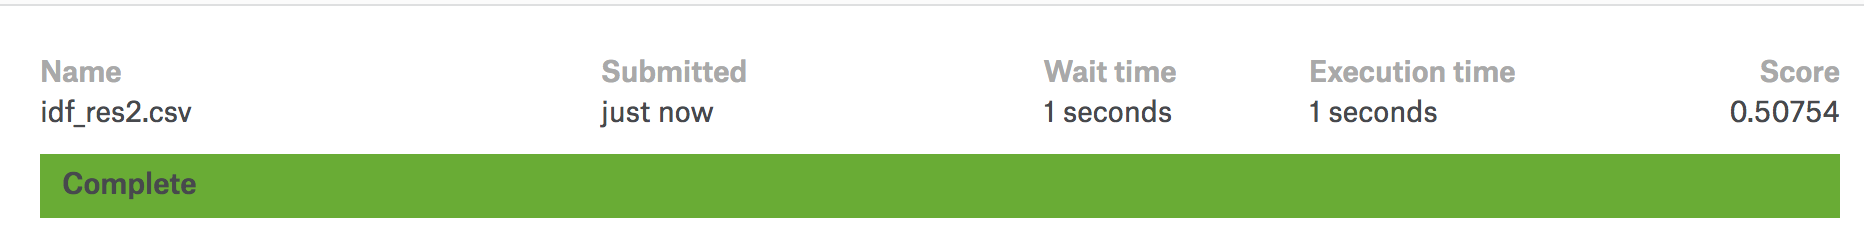

In [37]:
from IPython.display import Image

#result for linear regression
Image(filename='Desktop/task15/data/idf_res2_.pic.jpg')

## Previous Iteration results with our current Pipeline


## Features vector same as the best case as enlisted above but without category vector.

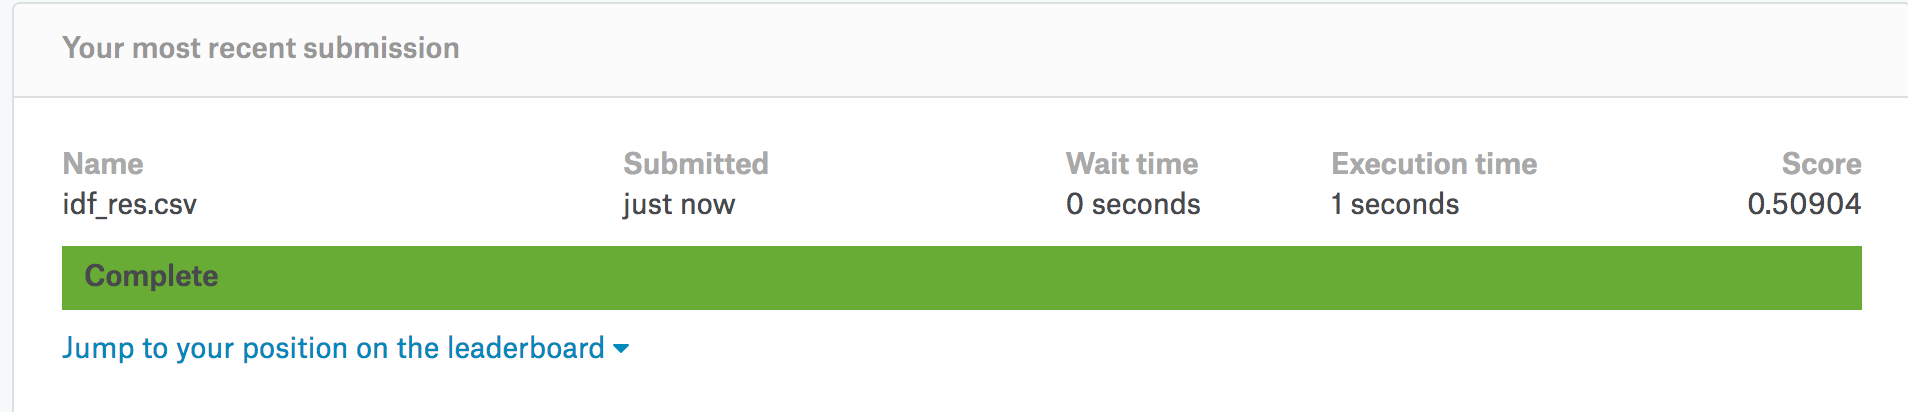

In [38]:
from IPython.display import Image

#result for linear regression
Image(filename='Desktop/task15/data/idf_res1.jpg')

## Features vector consists of cosine similarity between title, description with search term, without any stemming

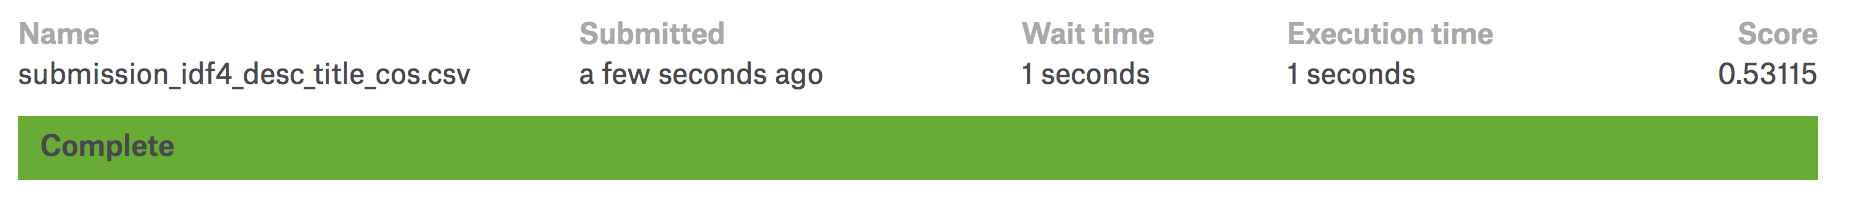

In [39]:
from IPython.display import Image

#result for linear regression
Image(filename='Desktop/task15/data/sub_idf_desc_title_cos.png') 

## Features vector consists of jaccard similarity between title, description, value, category, brand, color, and material with search term, without any stemming

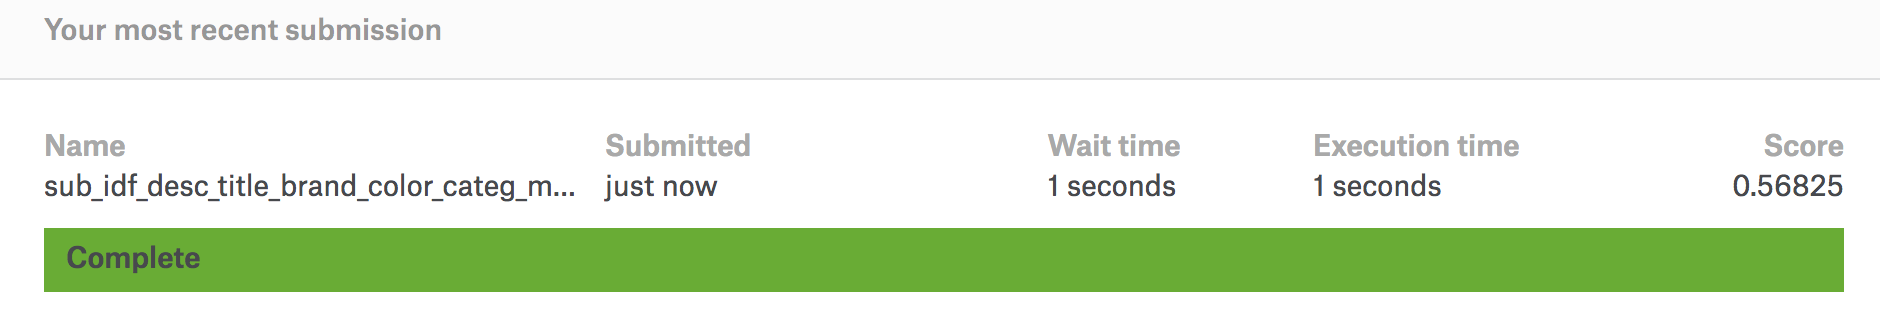

In [40]:
from IPython.display import Image

#result for linear regression
Image(filename='Desktop/task15/data/jac4 with_value.png') 

## Loading Train data

In [3]:
# Loading files
train=pd.read_csv("~/Desktop/task15/data/train.csv", encoding = 'latin1')
test=pd.read_csv("~/Desktop/task15/data/test.csv", encoding = 'latin1')
attr=pd.read_csv("~/Desktop/task15/data/attributes.csv", encoding = 'latin1')
desc=pd.read_csv("~/Desktop/task15/data/product_descriptions.csv", encoding = 'latin1')
train.head()




,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


## Added a new column called category to the attribute using Home Depot website's departments

In [4]:
import re
regexBath = re.compile('bath|faucets?|showerheads?|bathtubs?|whirlpools?|showers?|bathrooms?|sinks?|bathrooms?|baths?|toilets?|bidets?')
regexAppliances = re.compile('refrigerators?|freezers|ice makers|washers|dryers|dishwashers|appliances|appliance|kitchen packages|vacuum cleaners|water heater[s]?|garbage disposal[s]')
regexDecor = re.compile('blind[s]?|window[s]?|furniture[s]?|decoration[s]?|decor[s]?|wallpaper[s]?|home accent[s]?|rug[s]?|paint[s]?') 
regexBuildingMat = re.compile('lumber|composites|fencing|decking|drywall|door[s]?|window[s]?|roofing|gutters|siding|insulation|concrete|cement|masonry|ceiling[s]?|hardware|fastener[s]?|moulding[s]?|millwork|ladder[s]?')
regexDoorsWindows = re.compile('door[s]?|window[s]?|blind[s]?|shutter[s]?|awning[s]?|skylight[s]?')
regexElectrical = re.compile('wire[s]?|bulb[s]?|surveillance|security|conduit[s]?|fitting[s]?|smart home|circuit[s]?|panel[s]?|cord[s]?|surge[s]?|electronic[s]|plate[s]?|jack[s]?|tool[s]?|generator[s]?|dimmer[s]|switch|switches|outlet[s]|safety')
regexFloor = re.compile('rug[s]?|mat[s]?|carpet[s]?|tile[s]|floor[s]?|flooring[s]?')
regexHardware = re.compile('cabinet[s]?|hardware[s]?|chain[s]?|rope[s]|key[s]?|mailbox|post[s]?|address|sheet[s]?|rod[s]?|screw[s]?|nail[s]?|anchor[s]?|sign[s]?|strap[s]?|bungee[s]?')
regexHeatingCooling = re.compile ('heater[s]?|thermostat[s]?|air|hvac|conditioner[s]?|cooler[s]?|fireplace[s]?|hearth[s]?|ventilation[s]?|fan[s]?')

regexKitchen = re.compile('cabinet[s]?|cabinet hardware[s]?|kitchen sink[s]?|kitchen faucet[s]?|kitchen remodeling[s]?|countertop[s]?|backsplashes?|garbage disposal[s]?|tableware?|bar?|kitchen storage & organization|small appliances|cooking|food preparation|cart[s]?|island[s]?|utility table[s]?|cleaning supplies')
regexLawnGarden = re.compile('garden plant[s]?|tree[s]?|bushes?|lawn care|lawn mower[s]?|garden club[s]?|landscaping|outdoor power equipment[s]?|garden tool[s]?|pot[s]?|planter[s]?|watering?|irrigation[s]?|insect[s]?|pest control|fencing|greenhouses|shed[s]?|garage[s]?|outdoor storage')
regexLightingCeilingFans = re.compile('ceiling fan[s]?|accessories|outdoor lighting|ceiling light[s]?|hanging light[s]?|wall lighting[s]?|led light fixtures|commercial lighting[s]?|under cabinet lighting[s]?|light bulb[s]?|indoor lighting accessories|lamp[s]?|shades')
regexOutdoorLiving = re.compile('patio furniture|grill[s]?|grill accessories|outdoor power equipment[s]?|fencing|playset[s]?|recreation[s]?|decking|shed[s]?|outdoor storage|patio gazebo[s]?|pergolas|outdoor heating|pool[s]?|pool supplies|hot tub[s]?|sauna[s]?')
regexPaint = re.compile('interior paint[s]?|exterior paint[s]?|primer[s]?|paint sprayer[s]?|paint supplies|spray paint[s]?|furniture paint[s]?|craft paint[s]?|exterior stain[s]?|interior stain[s]?|concrete|garage floor paint[s]?|waterproofing|sealer[s]?|caulking|sealant[s]?|duct tape|glue[s]?|epoxy|shop top brand[s]?')
regexPlumbing = re.compile('water heater[s]?|part[s]?|repair|pipe[s]?|fitting[s]?|valve[s]?|plumbing tool[s]?|pump[s]?|drain opener[s]?|kitchen faucet[s]?|bath faucet[s]?|showerhead[s]?')
regexStorageOrganization = re.compile('closet storage[s]?|moving boxes|supplies|shed[s]?|garages|outdoor storage[s]?|garage storage[s]?|storage bin[s]?|tote[s]?|shelves|shelf bracket[s]?|locker[s]?|cube storage[s]?|accessories|cleaning')
regexTools = re.compile('power tool[s]?|hand tool[s]?|air compressor[s]?|air tool[s]?|outdoor power tool[s]?|tools storage[s]?|power tool accessories|automotive|workwear[s]?|safety gear|welding|soldering|wet vacuum[s]?|dry vacuum[s]?')



category = []
 
 
for row in attr['value']:
    flag =0
    catalag = ""
    if regexBath.search(str(row)):
        catalag+="Bath "
        flag = 1
    
    if regexAppliances.search(str(row)):
        catalag+="Appliances "
        flag = 1
 
    if regexDecor.search(str(row)):
        catalag+="Decor "
        flag = 1
 
    if regexBuildingMat.search(str(row)):
        catalag+="Building materials "
        flag = 1
        
    if regexDoorsWindows.search(str(row)):
        catalag+="Doors&Windows "
        flag = 1
        
    if regexElectrical.search(str(row)):
        catalag+="Electrical "
        flag = 1
        
    if regexFloor.search(str(row)):
        catalag=="Floor "
        flag = 1
        
    if regexHardware.search(str(row)):
        catalag+="Hardware "
        flag = 1
        
    if regexHeatingCooling.search(str(row)):
        catalag+="Heating&Cooling "
        flag = 1
    
    if regexKitchen.search(str(row)):
        catalag+="kitchen "
        flag = 1
    
    if regexLawnGarden.search(str(row)):
        catalag+="Lawn & Garden "
        flag = 1
    
    if regexLightingCeilingFans.search(str(row)):
        catalag+="Lighting & Ceiling fans "
        flag = 1
        
    if regexOutdoorLiving.search(str(row)):
        catalag+="Outdoor Living "
        flag = 1
        
    if regexPlumbing.search(str(row)):
        catalag+="Plumbing "
        flag = 1
        
    if regexPaint.search(str(row)):
        catalag+="Paint "
        flag = 1
        
    if regexStorageOrganization.search(str(row)):
        catalag+="Storage & Organization "
        flag = 1
        
    if regexTools.search(str(row)):
        catalag+="Tools "
        flag = 1
    
    
    
    if flag == 0:
        
        catalag+=""
    category.append(catalag)

attr['category'] = category
attr.head()





,product_uid,name,value,category
0,100001.0,Bullet01,Versatile connector for various 90å¡ connectio...,Heating&Cooling Plumbing
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...,Hardware
2,100001.0,Bullet03,Help ensure joints are consistently straight a...,
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.,
4,100001.0,Bullet05,Made from 12-Gauge steel,


In [5]:
category = attr.groupby('product_uid')['category'].agg(lambda x: ' '.join(x)).reset_index()
category.head()



,product_uid,category
0,100001.0,Heating&Cooling Plumbing Hardware Hardwa...
1,100002.0,Building materials Outdoor Living Paint ...
2,100003.0,Hardware Storage & Organization ...
3,100004.0,Electrical
4,100005.0,kitchen Plumbing


## Grouping by Value column from the attribute.csv

In [6]:
value = attr.groupby('product_uid')['value'].apply(lambda x: ' '.join(map(str,x))).reset_index()
value = value.rename(columns={"value":"value_merged"})
value.head()

,product_uid,value_merged
0,100001.0,Versatile connector for various 90å¡ connectio...
1,100002.0,"Brush,Roller,Spray 6.63 in 7.76 in 6.63 in Rev..."
2,100003.0,Yes Slightly narrower for tighter spaces Desig...
3,100004.0,8.56 Positive power tolerance (0 to +5-Watt) A...
4,100005.0,Combo Tub and Shower No Includes the trim kit ...


In [7]:
# Adding features [brand, material, color]
attr = attr[attr['value'] != 'No']
brand = attr[attr['name'] == "MFG Brand Name"]
material = attr[attr['name'] == "Material"]
color = attr[attr['name'] == 'Color Family']

material.head()


,product_uid,name,value,category
8,100001.0,Material,Galvanized Steel,
67,100003.0,Material,Composite,
202,100007.0,Material,Plastic,
255,100009.0,Material,Medium Density Fiberboard (MDF),
282,100010.0,Material,Steel,


In [8]:
color = color.groupby('product_uid')['value'].apply(' '.join).reset_index()
material = material.groupby('product_uid')['value'].apply(lambda x: ' '.join(map(str,x))).reset_index()
material.head()

,product_uid,value
0,100001.0,Galvanized Steel
1,100003.0,Composite
2,100007.0,Plastic
3,100009.0,Medium Density Fiberboard (MDF)
4,100010.0,Steel


## Merging the train and test data with description, brand, material, color, category and value

In [9]:


# Adding features to train
train = train.merge(desc, on = "product_uid", how = 'left')
train = train.merge(brand, on = "product_uid", how = 'left')
train = train.merge(material, on = "product_uid", how = 'left')
train = train.merge(color, on = "product_uid", how = 'left')
train = train.merge(category, on = "product_uid", how = 'left')
train = train.merge(value, on = "product_uid", how = 'left')

del train['category_x']
del train['name']


train = train.rename(columns={"id":"id","product_uid":"product_uid", "product_title": "title", "search_term": "term", "relevance":"score", "product_description":"description", "value_x":"brand","value_y":"material","value":"color","category_y":"category"})


# Adding features to test
test = test.merge(desc, on = "product_uid", how = 'left')
test = test.merge(brand, on = "product_uid", how = 'left')
test = test.merge(material, on = "product_uid", how = 'left')
test = test.merge(color, on = "product_uid", how = 'left')
test = test.merge(category, on = "product_uid", how = 'left')
test = test.merge(value, on = "product_uid", how = 'left')


# del test['name_x']
del test['category_x']
del test['name']


test = test.rename(columns={"id":"id","product_uid":"product_uid", "product_title": "title", "search_term": "term", "product_description":"description", "value_x":"brand","value_y":"material","value":"color","category_y":"category"})


# Saving csv for test


#test.head(2)
train.head(2)

,id,product_uid,title,term,score,description,brand,material,color,category,value_merged
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.0,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,Galvanized Steel,NaN,Heating&Cooling Plumbing Hardware Hardwa...,Versatile connector for various 90å¡ connectio...
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.5,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,Galvanized Steel,NaN,Heating&Cooling Plumbing Hardware Hardwa...,Versatile connector for various 90å¡ connectio...


## Stemming words in title, description, term, brand and value
Reference --> https://www.kaggle.com/hellozeyu/test-script-1/code

In [10]:
import re
stemmer = SnowballStemmer("english")
def str_stem(s): 
    if isinstance(s, str):
        s = s.lower()
        s = re.sub(r"(\w)\.([A-Z])", r"\1 \2", s)

        s = re.sub(r"([0-9]+)( *)(inches|inch|in|')\.?", r"\1in. ", s)
    
        s = re.sub(r"([0-9]+)( *)(foot|feet|ft|'')\.?", r"\1ft. ", s)
    
        s = re.sub(r"([0-9]+)( *)(pounds|pound|lbs|lb)\.?", r"\1lb. ", s)
    
        s = s.replace(" x "," xby ")
        s = s.replace("*"," xby ")
        s = s.replace(" by "," xby")
        s = s.replace("x0"," xby 0")
        s = s.replace("x1"," xby 1")
        s = s.replace("x2"," xby 2")
        s = s.replace("x3"," xby 3")
        s = s.replace("x4"," xby 4")
        s = s.replace("x5"," xby 5")
        s = s.replace("x6"," xby 6")
        s = s.replace("x7"," xby 7")
        s = s.replace("x8"," xby 8")
        s = s.replace("x9"," xby 9")
        s = s.replace("0x","0 xby ")
        s = s.replace("1x","1 xby ")
        s = s.replace("2x","2 xby ")
        s = s.replace("3x","3 xby ")
        s = s.replace("4x","4 xby ")
        s = s.replace("5x","5 xby ")
        s = s.replace("6x","6 xby ")
        s = s.replace("7x","7 xby ")
        s = s.replace("8x","8 xby ")
        s = s.replace("9x","9 xby ")
        
        s = re.sub(r"([0-9]+)( *)(square|sq) ?\.?(feet|foot|ft)\.?", r"\1sq.ft. ", s)
    
        s = re.sub(r"([0-9]+)( *)(gallons|gallon|gal)\.?", r"\1gal. ", s)
        
        s = re.sub(r"([0-9]+)( *)(ounces|ounce|oz)\.?", r"\1oz. ", s)
    
        s = re.sub(r"([0-9]+)( *)(centimeters|cm)\.?", r"\1cm. ", s)
    
        s = re.sub(r"([0-9]+)( *)(milimeters|mm)\.?", r"\1mm. ", s)
        
        s = re.sub(r"([0-9]+)( *)(degrees|degree)\.?", r"\1deg. ", s)
    
        s = re.sub(r"([0-9]+)( *)(volts|volt)\.?", r"\1volt. ", s)
        
        s = re.sub(r"([0-9]+)( *)(watts|watt)\.?", r"\1watt. ", s)
    
        s = re.sub(r"([0-9]+)( *)(amperes|ampere|amps|amp)\.?", r"\1amp. ", s)
        
        s = s.replace("  "," ")
        s = (" ").join([stemmer.stem(z) for z in s.split(" ")])
        return s.lower()
    else:
        return "null"

In [11]:
train['term'] = train['term'].map(lambda x:str_stem(x))
train['title'] = train['title'].map(lambda x:str_stem(x))
train['description'] = train['description'].map(lambda x:str_stem(x))
train['brand'] = train['brand'].map(lambda x:str_stem(x))
train['value_merged'] = train['value_merged'].map(lambda x:str_stem(x))


test['term'] = test['term'].map(lambda x:str_stem(x))
test['title'] = test['title'].map(lambda x:str_stem(x))
test['description'] = test['description'].map(lambda x:str_stem(x))
test['brand'] = test['brand'].map(lambda x:str_stem(x))
test['value_merged'] = test['value_merged'].map(lambda x:str_stem(x))

train.head()

,id,product_uid,title,term,score,description,brand,material,color,category,value_merged
0,2,100001,simpson strong-ti 12-gaug angl,angl bracket,3.00,"not onli do angl make joint stronger, they als...",simpson strong-ti,Galvanized Steel,NaN,Heating&Cooling Plumbing Hardware Hardwa...,versatil connector for various 90å¡ connect an...
1,3,100001,simpson strong-ti 12-gaug angl,l bracket,2.50,"not onli do angl make joint stronger, they als...",simpson strong-ti,Galvanized Steel,NaN,Heating&Cooling Plumbing Hardware Hardwa...,versatil connector for various 90å¡ connect an...
2,9,100002,behr premium textur deckov 1-gal. #sc-141 tugb...,deck over,3.00,behr premium textur deckov is an innov solid c...,behr premium textur deckov,NaN,Browns / Tans,Building materials Outdoor Living Paint ...,"brush,roller,spray 6.63in. 7.76in. 6.63in. rev..."
3,16,100005,delta vero 1-handl shower onli faucet trim kit...,rain shower head,2.33,updat your bathroom with the delta vero single...,delta,NaN,Chrome,kitchen Plumbing,combo tub and shower no includ the trim kit on...
4,17,100005,delta vero 1-handl shower onli faucet trim kit...,shower onli faucet,2.67,updat your bathroom with the delta vero single...,delta,NaN,Chrome,kitchen Plumbing,combo tub and shower no includ the trim kit on...


In [12]:
test.to_csv('~/Desktop/task15/data/joinedtest.csv',index=False)
train.to_csv('~/Desktop/task15/data/joinedtrain.csv',index=False)


## Retrieving the merged train and test data with description, brand, material, color, category and value

In [13]:
# Creating spark dataframes from panda dataframes
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType,StringType,IntegerType
from pyspark.sql.functions import lit
from pyspark.sql.functions import col, when

# TRAIN
dataSchema = StructType([
    StructField("id", IntegerType()),
    StructField("pid", IntegerType()),
    StructField("title", StringType()),
    StructField("term", StringType()),
    StructField("score", DoubleType()),
    StructField("description", StringType()),
    StructField("brand", StringType()),
    StructField("material", StringType()),
    StructField("color", StringType()),
    StructField("category", StringType()),
    StructField("value", StringType())

])

train=sql_sc.read.format("com.databricks.spark.csv").option("header","true")\
   .schema(dataSchema).load("Desktop/task15/data/joinedtrain.csv")

    
def blank_as_null(x):
    return when(col(x) != 'null', col(x)).otherwise("")

train = train.withColumn("material", blank_as_null("material"))
train = train.withColumn("brand", blank_as_null("brand"))
train = train.withColumn("color", blank_as_null("color"))   
train = train.withColumn("category", blank_as_null("category"))   
train = train.withColumn("value", blank_as_null("value"))   

# TEST
testdataSchema = StructType([
    StructField("id", IntegerType()),
    StructField("pid", IntegerType()),
    StructField("title", StringType()),
    StructField("term", StringType()),
    StructField("description", StringType()),
    StructField("brand", StringType()),
    StructField("material", StringType()),
    StructField("color", StringType()),
    StructField("category", StringType()),
    StructField("value", StringType())

])

test=sql_sc.read.format("com.databricks.spark.csv").option("header","true")\
   .schema(testdataSchema).load("Desktop/task15/data/joinedtest.csv")

test = test.withColumn("material", blank_as_null("material"))
test = test.withColumn("brand", blank_as_null("brand"))
test = test.withColumn("color", blank_as_null("color"))
test = test.withColumn("category", blank_as_null("category"))   
test = test.withColumn("value", blank_as_null("value"))   

    
train.show()
test.show()

+---+------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+
| id|   pid|               title|                term|score|         description|               brand|            material|        color|            category|               value|
+---+------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+
|  2|100001|simpson strong-ti...|        angl bracket|  3.0|"not onli do angl...|   simpson strong-ti|    Galvanized Steel|             |Heating&Cooling P...|versatil connecto...|
|  3|100001|simpson strong-ti...|           l bracket|  2.5|"not onli do angl...|   simpson strong-ti|    Galvanized Steel|             |Heating&Cooling P...|versatil connecto...|
|  9|100002|behr premium text...|           deck over|  3.0|behr premium text...|behr premium text..

## Passing the train and test data to Tokenizer, Removing and Hashing TF

In [14]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, RegexTokenizer
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import StringIndexer

# Tokenizing
tokenizerTitle = Tokenizer(inputCol="title", outputCol="title_words")
tokenizerTerm = Tokenizer(inputCol="term", outputCol="term_words")
tokenizerDesc = Tokenizer(inputCol="description", outputCol="desc_words")
tokenizerValue = Tokenizer(inputCol="value", outputCol="value_words")
tokenizerCategory = Tokenizer(inputCol="category", outputCol="category_words")


# Removing Stop words
removerTitle = StopWordsRemover(inputCol="title_words", outputCol="filtered_title")
removerTerm = StopWordsRemover(inputCol="term_words", outputCol="filtered_term")
removerDesc = StopWordsRemover(inputCol="desc_words", outputCol="filtered_desc")
removerValue = StopWordsRemover(inputCol="value_words", outputCol="filtered_value")



#get the tf
hashingTitle = HashingTF(inputCol="filtered_title", outputCol="rawFeatures_title", numFeatures=20)
hashingTerm = HashingTF(inputCol="filtered_term", outputCol="rawFeatures_term", numFeatures=20)
hashingDesc = HashingTF(inputCol="filtered_desc", outputCol="rawFeatures_desc", numFeatures=20)
hashingValue = HashingTF(inputCol="filtered_value", outputCol="rawFeatures_value", numFeatures=20)
hashingCat = HashingTF(inputCol="category_words", outputCol="category_vector", numFeatures=20)



## Fitting the Pipeline with the above Transformers

In [15]:
# Make the Pipeline (Transformation)
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[tokenizerValue, tokenizerDesc, tokenizerTerm, tokenizerTitle,tokenizerCategory, removerValue, removerDesc, removerTerm, removerTitle,hashingValue,hashingCat, hashingDesc, hashingTerm, hashingTitle])
model = pipeline.fit(train)
test = model.transform(test)
train = model.transform(train)
test.show()
train.show()

+---+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| id|   pid|               title|                term|         description|               brand|            material|   color|            category|               value|         value_words|          desc_words|          term_words|         title_words|      category_words|      filtered_value|       filtered_desc|       filtered_term|      filtered_title|   rawFeatures_value|     category_vector|    rawFeatures_desc|    rawFeatures_term|   rawFeatures_title|
+---+------+--------------------+--------------------+--------------------

## Computing the IDF vectors on Title, Term, Description and Value

In [16]:

from pyspark.ml.feature import HashingTF, IDF, Tokenizer, RegexTokenizer
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import StringIndexer




#get the idf
idfTitle = IDF(inputCol="rawFeatures_title", outputCol="title_idf")
idfModel = idfTitle.fit(train)
train = idfModel.transform(train)
idfModel = idfTitle.fit(test)
test = idfModel.transform(test)

idfTerm = IDF(inputCol="rawFeatures_term", outputCol="term_idf")
idfModel = idfTerm.fit(train)
train = idfModel.transform(train)
idfModel = idfTerm.fit(test)
test = idfModel.transform(test)


idfDesc = IDF(inputCol="rawFeatures_desc", outputCol="desc_idf")
idfModel = idfDesc.fit(train)
train = idfModel.transform(train)
idfModel = idfDesc.fit(test)
test = idfModel.transform(test)



idfValue = IDF(inputCol="rawFeatures_value", outputCol="value_idf")
idfModel = idfValue.fit(train)
train = idfModel.transform(train)
idfModel = idfValue.fit(test)
test = idfModel.transform(test)


train.show()
test.show()








+---+------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| id|   pid|               title|                term|score|         description|               brand|            material|        color|            category|               value|         value_words|          desc_words|          term_words|         title_words|      category_words|      filtered_value|       filtered_desc|       filtered_term|      filtered_title|   rawFeatures_value|     category_vector|    rawFeatures_desc|    rawFeat

## Calculating Cosine Similarity between two IDF vectors

In [17]:
# Cosine Similarity
import math
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql.functions import udf

def cosineSimilarity(v1,v2):
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]
        y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return float(sumxy/math.sqrt(sumxx*sumyy))
idfUDF=udf(cosineSimilarity, DoubleType())

In [18]:
train= train.withColumn("term_title_cos", idfUDF("term_idf","title_idf"))
train=train.withColumn("term_desc_cos", idfUDF("term_idf","desc_idf"))
# train=train.withColumn("term_value_cos", idfUDF("term_idf","value_idf"))

test= test.withColumn("term_title_cos", idfUDF("term_idf","title_idf"))
test=test.withColumn("term_desc_cos", idfUDF("term_idf","desc_idf"))
# test=test.withColumn("term_value_cos", idfUDF("term_idf","value_idf"))

train.show()
test.show()

+---+------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+
| id|   pid|               title|                term|score|         description|               brand|            material|        color|            category|               value|         value_words|          desc_words|          term_words|         title_words|      category_words|      filtered_value|       filtered_desc|       filtered_term|      filtered_title|   rawFeatures_value|     category

## Finding the match words between title, description and value words with search term words

In [59]:
# get the number of match words in term and title
def matchWords(title,term):
    l1=len(title)
    l2=len(term)
    match=0
    for i in range(l1):
        for j in range(l2):
            if title[i] == term[j]:
                match+=2
            elif title[i] in term[j]:
                match+=1
            elif term[j] in title[i]:
                match+=1
    return match
matchUDF=udf(matchWords, IntegerType())

In [20]:
train= train.withColumn("term_title_match", matchUDF("term_words","title_words"))
train=train.withColumn("term_desc_match", matchUDF("term_words","desc_words"))
train=train.withColumn("term_value_match", matchUDF("term_words","value_words"))


test= test.withColumn("term_title_match", matchUDF("term_words","title_words"))
test=test.withColumn("term_desc_match", matchUDF("term_words","desc_words"))
test=test.withColumn("term_value_match", matchUDF("term_words","value_words"))

train.show()
test.show()

+---+------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+----------------+---------------+----------------+
| id|   pid|               title|                term|score|         description|               brand|            material|        color|            category|               value|         value_words|          desc_words|          term_words|         title_words|      category_words|      filtered_value|       filtered_desc|       filtered_term|     

## Finding the jaccard similarity between title, description and value words with search term words

In [21]:
# Jaccard Simm
from sklearn.metrics import jaccard_similarity_score
from math import*
def jaccard_similarity(x,y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)
jaccardUDF=udf(jaccard_similarity, DoubleType())

In [22]:
train=train.withColumn("term_desc_jaccard", jaccardUDF("term_words","desc_words"))
train= train.withColumn("term_title_jaccard", jaccardUDF("term_words","title_words"))
train=train.withColumn("term_value_jaccard", jaccardUDF("term_words","value_words"))
# train=train.withColumn("term_cat_jaccard", jaccardUDF("term_words","category_words"))

test= test.withColumn("term_title_jaccard", jaccardUDF("term_words","title_words"))
test=test.withColumn("term_desc_jaccard", jaccardUDF("term_words","desc_words"))
test=test.withColumn("term_value_jaccard", jaccardUDF("term_words","value_words"))
# test=test.withColumn("term_cat_jaccard", jaccardUDF("term_words","category_words"))

train.show()
test.show()

+---+------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+----------------+---------------+----------------+--------------------+--------------------+--------------------+
| id|   pid|               title|                term|score|         description|               brand|            material|        color|            category|               value|         value_words|          desc_words|          term_words|         title_words|      category_words|     

## Finding whether any word in attributes such as brand is present within the search term

In [23]:
def attrInTerm(attr, term):
    if attr in term:
        return 100
    else: return 1
attrInTermFunc=udf(attrInTerm, IntegerType())

In [24]:
train=train.withColumn("brand_term", attrInTermFunc("brand","term_words"))
train=train.withColumn("material_term", attrInTermFunc("material","term_words"))
train=train.withColumn("color_term", attrInTermFunc("color","term_words"))


test=test.withColumn("brand_term", attrInTermFunc("brand","term_words"))
test=test.withColumn("material_term", attrInTermFunc("material","term_words"))
test=test.withColumn("color_term", attrInTermFunc("color","term_words"))


train.show()
test.show()

+---+------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+----------------+---------------+----------------+--------------------+--------------------+--------------------+----------+-------------+----------+
| id|   pid|               title|                term|score|         description|               brand|            material|        color|            category|               value|         value_words|          desc_words|          term_words|         ti

## Assembled the output of the cosine similarity, match words and jaccard similarity and attrinTerm features into an aggregate features column. 

In [25]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer,StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark import SparkContext
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType,StringType,IntegerType
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler

#put all the needed feature to a vector
# features=["color_term","material_term", "brand_term","term_title_match", "term_title_jaccard", "term_desc_match", "term_desc_jaccard","term_value_jaccard","term_cat_jaccard","term_value_match", "term_title_cos", "term_desc_cos"]
# features=["term_title_match", "term_title_jaccard", "term_desc_match", "term_desc_jaccard","term_value_jaccard","term_cat_jaccard","term_value_match", "term_title_cos", "term_desc_cos"]
# features=["brand_term","term_title_match", "term_title_jaccard", "term_desc_match", "term_desc_jaccard","term_value_jaccard","term_value_match", "term_title_cos", "term_desc_cos"]
#features=["brand_term","term_title_match", "term_title_jaccard", "term_desc_match", "term_desc_jaccard","term_value_jaccard","term_value_match", "term_title_cos", "term_desc_cos"]

features=["brand_term","term_title_match", "term_title_jaccard", "term_desc_match", "term_desc_jaccard","term_value_jaccard","term_value_match", "term_title_cos", "term_desc_cos", "category_vector"]
features2=["brand_term","term_title_match", "term_title_jaccard", "term_desc_match", "term_desc_jaccard","term_value_jaccard","term_value_match", "category_vector"]


assembler_features = VectorAssembler(inputCols=features, outputCol='features')
assembler_features2 = VectorAssembler(inputCols=features2, outputCol='features')

fin_train = assembler_features.transform(train)
fin_test = assembler_features.transform(test)

fin_train2 = assembler_features2.transform(train)
fin_test2 = assembler_features2.transform(test)


fin_train.show()
fin_test.show()

+---+------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+----------------+---------------+----------------+--------------------+--------------------+--------------------+----------+-------------+----------+--------------------+
| id|   pid|               title|                term|score|         description|               brand|            material|        color|            category|               value|         value_words|          desc_words|          t

In [26]:
fin_train2.show()
fin_test2.show()

+---+------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+----------------+---------------+----------------+--------------------+--------------------+--------------------+----------+-------------+----------+--------------------+
| id|   pid|               title|                term|score|         description|               brand|            material|        color|            category|               value|         value_words|          desc_words|          t

## Adding the Linear Regression estimator to the pipeline and fitting on the train to transform the test  

Since the Linear Regression estimator practically performs the same as our BaseLine model giving constant mean prediction value of 2.38 for all ids, we decided to fit the Random Forest Estimator in the following cell.

In [27]:
from pyspark.ml.regression import LinearRegression


lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, labelCol='score')
#print(lr.explainParams())
lrModel = lr.fit(fin_train2)
predictionlr = lrModel.transform(fin_test2)
predictionlr.show()


+---+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+----------------+---------------+----------------+-------------------+--------------------+--------------------+----------+-------------+----------+--------------------+------------------+
| id|   pid|               title|                term|         description|               brand|            material|   color|            category|               value|         value_words|          desc_words|          term

In [29]:
# Print the coefficients and intercept for linear regression
trainingSummary = lrModel.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))


RMSE: 0.533980
Coefficients: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
Intercept: 2.3816337910269936


## Adding the RF estimator to the pipeline and fitting on the train to transform the test  

In [28]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol="features",labelCol='score', numTrees=11,maxDepth=5, maxBins = 3728)
#rf = RandomForestRegressor(featuresCol="features",labelCol='score', numTrees=30,maxDepth=10, maxBins = 3728)

pipeline = Pipeline(stages=[rf])
model = pipeline.fit(fin_train)
predictions = model.transform(fin_test)

predictions.show()

+---+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+----------------+---------------+----------------+-------------------+--------------------+--------------------+----------+-------------+----------+--------------------+------------------+
| id|   pid|               title|                term|         description|               brand|            material|   color|            category|               value|         value_words|          desc_words|          term

## Splitting the train data into 80:20 % to validate the train and calculate RMSE on train

In [30]:
(trainD, validD) = fin_train.randomSplit([0.8, 0.2])
#featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=5).fit(trainD)
rf = RandomForestRegressor(featuresCol="features",labelCol='score', numTrees=11,maxDepth=5,maxBins=20000)
pipeline = Pipeline(stages=[rf])
model = pipeline.fit(trainD)
predictionTrain = model.transform(validD)

In [31]:
evaluator = RegressionEvaluator(labelCol="score",predictionCol="prediction")
rmse = evaluator.evaluate(predictionTrain,{evaluator.metricName:"rmse"})
mse = evaluator.evaluate(predictionTrain,{evaluator.metricName:"mse"})
r2 = evaluator.evaluate(predictionTrain,{evaluator.metricName:"r2"})
mae = evaluator.evaluate(predictionTrain,{evaluator.metricName:"mae"})
print("Root Mean Squared Error (RMSE) on validating train data = %g" % rmse)
print("Mean Squared Error (MSE) on validating train data = %g" % mse)
print("R^2 metric (R2) on test data = %g" % r2)
print("Mean Absolute Error (MAE) on validating train data = %g" % mae)

Root Mean Squared Error (RMSE) on validating train data = 0.507268
Mean Squared Error (MSE) on validating train data = 0.25732
R^2 metric (R2) on test data = 0.0908523
Mean Absolute Error (MAE) on validating train data = 0.415049


## Writing the result to a csv

In [144]:
wr = predictions.select('id','prediction')
wr.coalesce(1).write.csv("Downloads/idf_rf_result2.csv")


In [25]:
wr.count()

166693

___  
___

## Pipeline2 - Tokenizer - StopWordsRemover - Word2Vec - Cosine Similarity - Match Words - Jaccard Similarity - RandomForest


Assembled the following features:  
Found the jaccard similarity between Description,Title,Value,Category and Term words;  
Found the match words between Description,Title,Value,Brand and Term words;  
Found the cosine similarity between Description,Title and Term vector.  
Assembled the aforementioned vectors into features and fitted it into Random Forest estimator.  
Got an improved RMSE result on test (0.50651) on kaggle. 


## Best Result with Pipeline2

## RMSE on Test of 0.50651

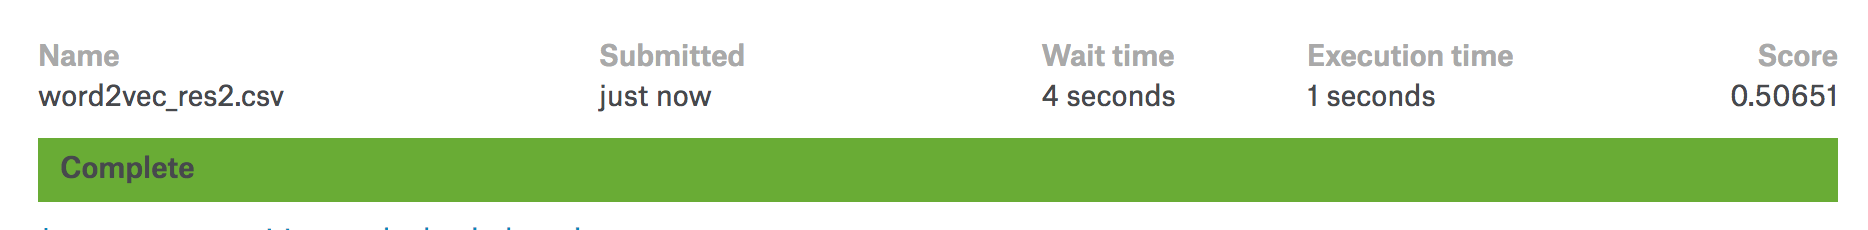

In [60]:
from IPython.display import Image

#result for linear regression
Image(filename='Desktop/task15/data/word2vec_res2.png')

## Previous Iteration Results

## Features vector same as the aforementioned best case but without stemming

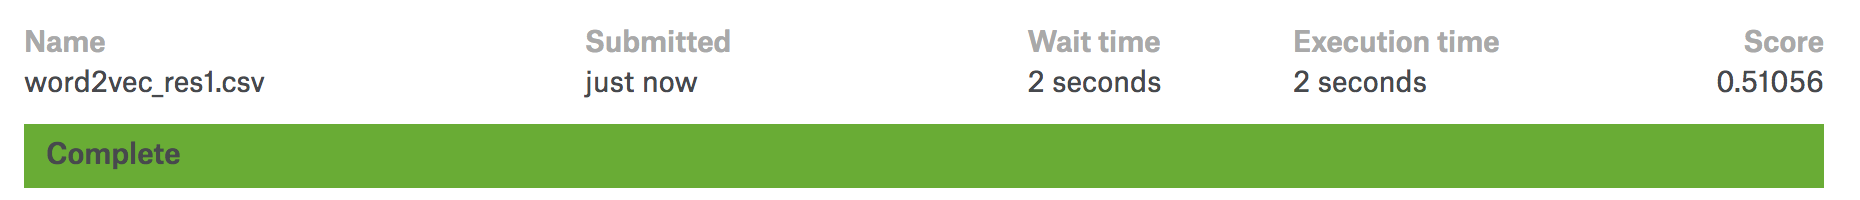

In [98]:
from IPython.display import Image

#result for linear regression
Image(filename='Desktop/task15/data/word2vec_res1.png')

## Features vector assembled by combining jaccard similarity of title, description, category, brand, material, color and value with term vector

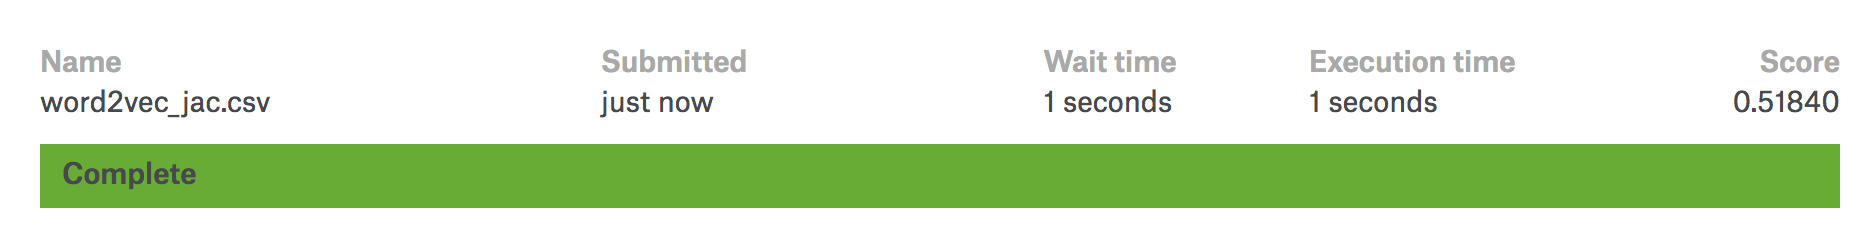

In [99]:
from IPython.display import Image

#result for linear regression
Image(filename='Desktop/task15/data/word2vec_jac.png')

## Loading the train data

In [65]:

# Loading files
train2=pd.read_csv("~/Desktop/task15/data/train.csv", encoding = 'latin1')
test2=pd.read_csv("~/Desktop/task15/data/test.csv", encoding = 'latin1')
attr=pd.read_csv("~/Desktop/task15/data/attributes.csv", encoding = 'latin1')
desc=pd.read_csv("~/Desktop/task15/data/product_descriptions.csv", encoding = 'latin1')
train2.head()



,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


## Added a new column called category to the attribute using Home Depot website's departments

In [66]:
import re
regexBath = re.compile('bath|faucets?|showerheads?|bathtubs?|whirlpools?|showers?|bathrooms?|sinks?|bathrooms?|baths?|toilets?|bidets?')
regexAppliances = re.compile('refrigerators?|freezers|ice makers|washers|dryers|dishwashers|appliances|appliance|kitchen packages|vacuum cleaners|water heater[s]?|garbage disposal[s]')
regexDecor = re.compile('blind[s]?|window[s]?|furniture[s]?|decoration[s]?|decor[s]?|wallpaper[s]?|home accent[s]?|rug[s]?|paint[s]?') 
regexBuildingMat = re.compile('lumber|composites|fencing|decking|drywall|door[s]?|window[s]?|roofing|gutters|siding|insulation|concrete|cement|masonry|ceiling[s]?|hardware|fastener[s]?|moulding[s]?|millwork|ladder[s]?')
regexDoorsWindows = re.compile('door[s]?|window[s]?|blind[s]?|shutter[s]?|awning[s]?|skylight[s]?')
regexElectrical = re.compile('wire[s]?|bulb[s]?|surveillance|security|conduit[s]?|fitting[s]?|smart home|circuit[s]?|panel[s]?|cord[s]?|surge[s]?|electronic[s]|plate[s]?|jack[s]?|tool[s]?|generator[s]?|dimmer[s]|switch|switches|outlet[s]|safety')
regexFloor = re.compile('rug[s]?|mat[s]?|carpet[s]?|tile[s]|floor[s]?|flooring[s]?')
regexHardware = re.compile('cabinet[s]?|hardware[s]?|chain[s]?|rope[s]|key[s]?|mailbox|post[s]?|address|sheet[s]?|rod[s]?|screw[s]?|nail[s]?|anchor[s]?|sign[s]?|strap[s]?|bungee[s]?')
regexHeatingCooling = re.compile ('heater[s]?|thermostat[s]?|air|hvac|conditioner[s]?|cooler[s]?|fireplace[s]?|hearth[s]?|ventilation[s]?|fan[s]?')

regexKitchen = re.compile('cabinet[s]?|cabinet hardware[s]?|kitchen sink[s]?|kitchen faucet[s]?|kitchen remodeling[s]?|countertop[s]?|backsplashes?|garbage disposal[s]?|tableware?|bar?|kitchen storage & organization|small appliances|cooking|food preparation|cart[s]?|island[s]?|utility table[s]?|cleaning supplies')
regexLawnGarden = re.compile('garden plant[s]?|tree[s]?|bushes?|lawn care|lawn mower[s]?|garden club[s]?|landscaping|outdoor power equipment[s]?|garden tool[s]?|pot[s]?|planter[s]?|watering?|irrigation[s]?|insect[s]?|pest control|fencing|greenhouses|shed[s]?|garage[s]?|outdoor storage')
regexLightingCeilingFans = re.compile('ceiling fan[s]?|accessories|outdoor lighting|ceiling light[s]?|hanging light[s]?|wall lighting[s]?|led light fixtures|commercial lighting[s]?|under cabinet lighting[s]?|light bulb[s]?|indoor lighting accessories|lamp[s]?|shades')
regexOutdoorLiving = re.compile('patio furniture|grill[s]?|grill accessories|outdoor power equipment[s]?|fencing|playset[s]?|recreation[s]?|decking|shed[s]?|outdoor storage|patio gazebo[s]?|pergolas|outdoor heating|pool[s]?|pool supplies|hot tub[s]?|sauna[s]?')
regexPaint = re.compile('interior paint[s]?|exterior paint[s]?|primer[s]?|paint sprayer[s]?|paint supplies|spray paint[s]?|furniture paint[s]?|craft paint[s]?|exterior stain[s]?|interior stain[s]?|concrete|garage floor paint[s]?|waterproofing|sealer[s]?|caulking|sealant[s]?|duct tape|glue[s]?|epoxy|shop top brand[s]?')
regexPlumbing = re.compile('water heater[s]?|part[s]?|repair|pipe[s]?|fitting[s]?|valve[s]?|plumbing tool[s]?|pump[s]?|drain opener[s]?|kitchen faucet[s]?|bath faucet[s]?|showerhead[s]?')
regexStorageOrganization = re.compile('closet storage[s]?|moving boxes|supplies|shed[s]?|garages|outdoor storage[s]?|garage storage[s]?|storage bin[s]?|tote[s]?|shelves|shelf bracket[s]?|locker[s]?|cube storage[s]?|accessories|cleaning')
regexTools = re.compile('power tool[s]?|hand tool[s]?|air compressor[s]?|air tool[s]?|outdoor power tool[s]?|tools storage[s]?|power tool accessories|automotive|workwear[s]?|safety gear|welding|soldering|wet vacuum[s]?|dry vacuum[s]?')



category = []
 
 
for row in attr['value']:
    flag =0
    catalag = ""
    if regexBath.search(str(row)):
        catalag+="Bath "
        flag = 1
    
    if regexAppliances.search(str(row)):
        catalag+="Appliances "
        flag = 1
 
    if regexDecor.search(str(row)):
        catalag+="Decor "
        flag = 1
 
    if regexBuildingMat.search(str(row)):
        catalag+="Building materials "
        flag = 1
        
    if regexDoorsWindows.search(str(row)):
        catalag+="Doors&Windows "
        flag = 1
        
    if regexElectrical.search(str(row)):
        catalag+="Electrical "
        flag = 1
        
    if regexFloor.search(str(row)):
        catalag=="Floor "
        flag = 1
        
    if regexHardware.search(str(row)):
        catalag+="Hardware "
        flag = 1
        
    if regexHeatingCooling.search(str(row)):
        catalag+="Heating&Cooling "
        flag = 1
    
    if regexKitchen.search(str(row)):
        catalag+="kitchen "
        flag = 1
    
    if regexLawnGarden.search(str(row)):
        catalag+="Lawn & Garden "
        flag = 1
    
    if regexLightingCeilingFans.search(str(row)):
        catalag+="Lighting & Ceiling fans "
        flag = 1
        
    if regexOutdoorLiving.search(str(row)):
        catalag+="Outdoor Living "
        flag = 1
        
    if regexPlumbing.search(str(row)):
        catalag+="Plumbing "
        flag = 1
        
    if regexPaint.search(str(row)):
        catalag+="Paint "
        flag = 1
        
    if regexStorageOrganization.search(str(row)):
        catalag+="Storage & Organization "
        flag = 1
        
    if regexTools.search(str(row)):
        catalag+="Tools "
        flag = 1
    
    
    
    if flag == 0:
        
        catalag+=""
    category.append(catalag)

attr['category'] = category


attr.head()



,product_uid,name,value,category
0,100001.0,Bullet01,Versatile connector for various 90å¡ connectio...,Heating&Cooling Plumbing
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...,Hardware
2,100001.0,Bullet03,Help ensure joints are consistently straight a...,
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.,
4,100001.0,Bullet05,Made from 12-Gauge steel,


## Grouping by Brand

In [67]:
# Adding features [brand, material, color]
attr = attr[attr['value'] != 'No']

#color = attr[attr['name'] == 'Color Family']
brand = attr[attr['name'] == "MFG Brand Name"]

attr.head()


,product_uid,name,value,category
0,100001.0,Bullet01,Versatile connector for various 90å¡ connectio...,Heating&Cooling Plumbing
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...,Hardware
2,100001.0,Bullet03,Help ensure joints are consistently straight a...,
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.,
4,100001.0,Bullet05,Made from 12-Gauge steel,


In [68]:

brand = brand.rename(columns={"value":"brand"})
del brand['name']
                        
brand.head()

,product_uid,brand,category
9,100001.0,Simpson Strong-Tie,
37,100002.0,BEHR Premium Textured DeckOver,
69,100003.0,STERLING,
93,100004.0,Grape Solar,
122,100005.0,Delta,


## Grouping by Category

In [69]:
category = attr.groupby('product_uid')['category'].apply(' '.join).reset_index()
category.head()

,product_uid,category
0,100001.0,Heating&Cooling Plumbing Hardware Hardwa...
1,100002.0,Building materials Outdoor Living Paint ...
2,100003.0,Hardware Storage & Organization ...
3,100004.0,Electrical
4,100005.0,kitchen Plumbing


## Grouping by Value

In [70]:
value = attr.groupby('product_uid')['value'].apply(lambda x: ' '.join(map(str,x))).reset_index()
value.head()

,product_uid,value
0,100001.0,Versatile connector for various 90å¡ connectio...
1,100002.0,"Brush,Roller,Spray 6.63 in 7.76 in 6.63 in Rev..."
2,100003.0,Yes Slightly narrower for tighter spaces Desig...
3,100004.0,8.56 Positive power tolerance (0 to +5-Watt) A...
4,100005.0,Combo Tub and Shower Includes the trim kit onl...


## Grouping by Material


In [71]:
material = attr[attr['name'] == "Material"]

material = material.rename(columns={"value":"material"})
del material['name']
                        
material.head()


,product_uid,material,category
8,100001.0,Galvanized Steel,
67,100003.0,Composite,
202,100007.0,Plastic,
255,100009.0,Medium Density Fiberboard (MDF),
282,100010.0,Steel,


In [72]:
material = material.groupby('product_uid')['material'].apply(' '.join).reset_index()
material.head()


,product_uid,material
0,100001.0,Galvanized Steel
1,100003.0,Composite
2,100007.0,Plastic
3,100009.0,Medium Density Fiberboard (MDF)
4,100010.0,Steel


## Grouping by Color

In [73]:
color = attr[attr['name'] == 'Color Family']
color = color.rename(columns={"value":"color"})
del color['name']
color.head()

,product_uid,color,category
30,100002.0,Browns / Tans,
58,100003.0,White,
114,100005.0,Chrome,
251,100009.0,White,
278,100010.0,Metallic,


In [74]:
color = color.groupby('product_uid')['color'].apply(' '.join).reset_index()
color.head()


,product_uid,color
0,100002.0,Browns / Tans
1,100003.0,White
2,100005.0,Chrome
3,100009.0,White
4,100010.0,Metallic


## Merging the train and test data with description, brand, material, color


In [75]:



# Adding features to train
train2 = train2.merge(desc, on = "product_uid", how = 'left')
train2 = train2.merge(brand, on = "product_uid", how = 'left')
train2 = train2.merge(material, on = "product_uid", how = 'left')
train2 = train2.merge(color, on = "product_uid", how = 'left')



del train2['category']

train2 = train2.rename(columns={"id":"id","product_uid":"product_uid", "product_title": "title", "search_term": "term", "relevance":"score", "product_description":"description", "name":"material","value":"brand"})







# Adding features to test
test2 = test2.merge(desc, on = "product_uid", how = 'left')
test2 = test2.merge(brand, on = "product_uid", how = 'left')
test2 = test2.merge(material, on = "product_uid", how = 'left')
test2 = test2.merge(color, on = "product_uid", how = 'left')


del test2['category']

test2 = test2.rename(columns={"id":"id","product_uid":"product_uid", "product_title": "title", "search_term": "term", "product_description":"description","name":"material", "value":"brand"})




train2.head(4)


,id,product_uid,title,term,score,description,brand,material,color
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,Galvanized Steel,NaN
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,Galvanized Steel,NaN
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...,BEHR Premium Textured DeckOver,NaN,Browns / Tans
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...,Delta,NaN,Chrome


## Merging the train data with category and value


In [76]:
train2 = train2.merge(category, on = "product_uid", how = 'left')
train2 = train2.merge(value, on = "product_uid", how = 'left')

train2.head()

,id,product_uid,title,term,score,description,brand,material,color,category,value
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,Galvanized Steel,NaN,Heating&Cooling Plumbing Hardware Hardwa...,Versatile connector for various 90å¡ connectio...
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,Galvanized Steel,NaN,Heating&Cooling Plumbing Hardware Hardwa...,Versatile connector for various 90å¡ connectio...
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...,BEHR Premium Textured DeckOver,NaN,Browns / Tans,Building materials Outdoor Living Paint ...,"Brush,Roller,Spray 6.63 in 7.76 in 6.63 in Rev..."
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...,Delta,NaN,Chrome,kitchen Plumbing,Combo Tub and Shower Includes the trim kit onl...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...,Delta,NaN,Chrome,kitchen Plumbing,Combo Tub and Shower Includes the trim kit onl...


## Stemming words in title, description, term, brand and value on train


In [77]:
train2['term'] = train2['term'].map(lambda x:str_stem(x))
train2['title'] = train2['title'].map(lambda x:str_stem(x))
train2['description'] = train2['description'].map(lambda x:str_stem(x))
train2['brand'] = train2['brand'].map(lambda x:str_stem(x))
train2['value'] = train2['value'].map(lambda x:str_stem(x))

In [78]:
train2.head()

,id,product_uid,title,term,score,description,brand,material,color,category,value
0,2,100001,simpson strong-ti 12-gaug angl,angl bracket,3.00,"not onli do angl make joint stronger, they als...",simpson strong-ti,Galvanized Steel,NaN,Heating&Cooling Plumbing Hardware Hardwa...,versatil connector for various 90å¡ connect an...
1,3,100001,simpson strong-ti 12-gaug angl,l bracket,2.50,"not onli do angl make joint stronger, they als...",simpson strong-ti,Galvanized Steel,NaN,Heating&Cooling Plumbing Hardware Hardwa...,versatil connector for various 90å¡ connect an...
2,9,100002,behr premium textur deckov 1-gal. #sc-141 tugb...,deck over,3.00,behr premium textur deckov is an innov solid c...,behr premium textur deckov,NaN,Browns / Tans,Building materials Outdoor Living Paint ...,"brush,roller,spray 6.63in. 7.76in. 6.63in. rev..."
3,16,100005,delta vero 1-handl shower onli faucet trim kit...,rain shower head,2.33,updat your bathroom with the delta vero single...,delta,NaN,Chrome,kitchen Plumbing,"combo tub and shower includ the trim kit only,..."
4,17,100005,delta vero 1-handl shower onli faucet trim kit...,shower onli faucet,2.67,updat your bathroom with the delta vero single...,delta,NaN,Chrome,kitchen Plumbing,"combo tub and shower includ the trim kit only,..."


In [79]:
#Saving csv for train
train2.to_csv('~/Desktop/task15/data/joinedtrain2.csv',index=False)

## Merging the test data with category and value


In [80]:
test2 = test2.merge(category, on = "product_uid", how = 'left')
test2 = test2.merge(value, on = "product_uid", how = 'left')

test2.head()


,id,product_uid,title,term,description,brand,material,color,category,value
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,Galvanized Steel,NaN,Heating&Cooling Plumbing Hardware Hardwa...,Versatile connector for various 90å¡ connectio...
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,Galvanized Steel,NaN,Heating&Cooling Plumbing Hardware Hardwa...,Versatile connector for various 90å¡ connectio...
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,Galvanized Steel,NaN,Heating&Cooling Plumbing Hardware Hardwa...,Versatile connector for various 90å¡ connectio...
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,Galvanized Steel,NaN,Heating&Cooling Plumbing Hardware Hardwa...,Versatile connector for various 90å¡ connectio...
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,Galvanized Steel,NaN,Heating&Cooling Plumbing Hardware Hardwa...,Versatile connector for various 90å¡ connectio...


## Stemming words in title, description, term, brand and value on test


In [81]:
test2['term'] = test2['term'].map(lambda x:str_stem(x))
test2['title'] = test2['title'].map(lambda x:str_stem(x))
test2['description'] = test2['description'].map(lambda x:str_stem(x))
test2['brand'] = test2['brand'].map(lambda x:str_stem(x))
test2['value'] = test2['value'].map(lambda x:str_stem(x))

In [82]:
test2.head()

,id,product_uid,title,term,description,brand,material,color,category,value
0,1,100001,simpson strong-ti 12-gaug angl,90deg. bracket,"not onli do angl make joint stronger, they als...",simpson strong-ti,Galvanized Steel,NaN,Heating&Cooling Plumbing Hardware Hardwa...,versatil connector for various 90å¡ connect an...
1,4,100001,simpson strong-ti 12-gaug angl,metal l bracket,"not onli do angl make joint stronger, they als...",simpson strong-ti,Galvanized Steel,NaN,Heating&Cooling Plumbing Hardware Hardwa...,versatil connector for various 90å¡ connect an...
2,5,100001,simpson strong-ti 12-gaug angl,simpson sku abl,"not onli do angl make joint stronger, they als...",simpson strong-ti,Galvanized Steel,NaN,Heating&Cooling Plumbing Hardware Hardwa...,versatil connector for various 90å¡ connect an...
3,6,100001,simpson strong-ti 12-gaug angl,simpson strong tie,"not onli do angl make joint stronger, they als...",simpson strong-ti,Galvanized Steel,NaN,Heating&Cooling Plumbing Hardware Hardwa...,versatil connector for various 90å¡ connect an...
4,7,100001,simpson strong-ti 12-gaug angl,simpson strong tie hcc668,"not onli do angl make joint stronger, they als...",simpson strong-ti,Galvanized Steel,NaN,Heating&Cooling Plumbing Hardware Hardwa...,versatil connector for various 90å¡ connect an...


In [83]:
# Saving csv for test
test2.to_csv('~/Desktop/task15/data/joinedtest2.csv',index=False)



## Retrieving the merged train and test and defining the data Schema on the same.

In [84]:
# Creating spark dataframes from panda dataframes
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType,StringType,IntegerType
from pyspark.sql.functions import lit
from pyspark.sql.functions import col, when

# TRAIN
dataSchema = StructType([
    StructField("id", IntegerType()),
    StructField("product_uid", IntegerType()),
    StructField("title", StringType()),
    StructField("term", StringType()),
    StructField("score", DoubleType()),
    StructField("description", StringType()),
    StructField("brand", StringType()),
    StructField("material", StringType()),
    StructField("color", StringType()),
    StructField("category", StringType()),
    StructField("value", StringType())


])

train2=sql_sc.read.format("com.databricks.spark.csv").option("header","true")\
   .schema(dataSchema).load("Desktop/task15/data/joinedtrain2.csv")

    
def blank_as_null(x):
    return when(col(x) != 'null', col(x)).otherwise("")

train2 = train2.withColumn("material", blank_as_null("material"))
train2 = train2.withColumn("brand", blank_as_null("brand"))
train2 = train2.withColumn("color", blank_as_null("color"))   
train2 = train2.withColumn("category", blank_as_null("category"))   
train2 = train2.withColumn("value", blank_as_null("value"))   


# TEST
testdataSchema = StructType([
    StructField("id", IntegerType()),
    StructField("product_uid", IntegerType()),
    StructField("title", StringType()),
    StructField("term", StringType()),
    StructField("description", StringType()),
    StructField("brand", StringType()),
    StructField("material", StringType()),
    StructField("color", StringType()),
    StructField("category", StringType()),
    StructField("value", StringType())

])

test2=sql_sc.read.format("com.databricks.spark.csv").option("header","true")\
   .schema(testdataSchema).load("Desktop/task15/data/joinedtest2.csv")

test2 = test2.withColumn("material", blank_as_null("material"))
test2 = test2.withColumn("brand", blank_as_null("brand"))
test2 = test2.withColumn("color", blank_as_null("color"))
test2 = test2.withColumn("category", blank_as_null("category"))   
test2 = test2.withColumn("value", blank_as_null("value"))   





    
train2.show()
test2.show()

+---+-----------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+
| id|product_uid|               title|                term|score|         description|               brand|            material|        color|            category|               value|
+---+-----------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+
|  2|     100001|simpson strong-ti...|        angl bracket|  3.0|"not onli do angl...|   simpson strong-ti|    Galvanized Steel|             |Heating&Cooling P...|versatil connecto...|
|  3|     100001|simpson strong-ti...|           l bracket|  2.5|"not onli do angl...|   simpson strong-ti|    Galvanized Steel|             |Heating&Cooling P...|versatil connecto...|
|  9|     100002|behr premium text...|           deck over|  3.0|behr premi

## Transforming the train and test data through Tokenizer

In [85]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, RegexTokenizer
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import StringIndexer

# Tokenizing
tokenizerTitle = Tokenizer(inputCol="title", outputCol="title_words")
tokenizerTerm = Tokenizer(inputCol="term", outputCol="term_words")
tokenizerDesc = Tokenizer(inputCol="description", outputCol="desc_words")
tokenizerValue = Tokenizer(inputCol="value", outputCol="value_words")
tokenizerCat = Tokenizer(inputCol="category", outputCol="category_words")
tokenizerBrand = Tokenizer(inputCol="brand", outputCol="brand_words")
tokenizerColor = Tokenizer(inputCol="color", outputCol="color_words")
tokenizerMat = Tokenizer(inputCol="material", outputCol="material_words")


# Removing Stop words
removerTitle = StopWordsRemover(inputCol="title_words", outputCol="filtered_title")
removerTerm = StopWordsRemover(inputCol="term_words", outputCol="filtered_term")
removerDesc = StopWordsRemover(inputCol="desc_words", outputCol="filtered_desc")
removerValue = StopWordsRemover(inputCol="value_words", outputCol="filtered_value")
removerCat = StopWordsRemover(inputCol="category_words", outputCol="filtered_category")
removerBrand = StopWordsRemover(inputCol="brand_words", outputCol="filtered_brand")
removerColor = StopWordsRemover(inputCol="color_words", outputCol="filtered_color")
removerMat = StopWordsRemover(inputCol="material_words", outputCol="filtered_material")



## Fitting the pipeline with the above Transformers

In [86]:
# Make the Pipeline (Transformation)

from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[tokenizerMat, tokenizerColor, tokenizerBrand, tokenizerCat, tokenizerValue, tokenizerDesc, tokenizerTerm, tokenizerTitle, removerMat, removerColor, removerBrand, removerCat, removerValue, removerDesc, removerTerm, removerTitle])

model1 = pipeline.fit(train2)


train2 = model1.transform(train2)
#model2 = pipeline.fit(test)
#test = model2.transform(test)
test2 = model1.transform(test2)




train2.show()
test2.show()


+---+-----------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| id|product_uid|               title|                term|score|         description|               brand|            material|        color|            category|               value|      material_words|      color_words|         brand_words|      category_words|         value_words|          desc_words|          term_words|         title_words|   filtered_material|   filtered_color|      filtered_brand|   filtered_category|      filtered_value|       filtered_desc|       filter

## Computing the word2vec vectors on all the features

In [87]:

from pyspark.ml.feature import Word2Vec

word2VecTitle = Word2Vec(vectorSize=3, minCount=0, inputCol="filtered_title", outputCol="title_vector")
model1 = word2VecTitle.fit(train2)
train2 = model1.transform(train2)
model2 = word2VecTitle.fit(test2)
test2 = model2.transform(test2)

word2VecTerm = Word2Vec(vectorSize=3, minCount=0, inputCol="filtered_term", outputCol="term_vector")
model1 = word2VecTerm.fit(train2)
train2 = model1.transform(train2)
model2 = word2VecTerm.fit(test2)
test2 = model2.transform(test2)

# Learn a mapping from words to Vectors.
word2VecDesc = Word2Vec(vectorSize=3, minCount=0, inputCol="filtered_desc", outputCol="desc_vector")
model1 = word2VecDesc.fit(train2)
train2 = model1.transform(train2)
model2 = word2VecDesc.fit(test2)
test2 = model2.transform(test2)

word2VecVal = Word2Vec(vectorSize=3, minCount=0, inputCol="filtered_value", outputCol="value_vector")
model1 = word2VecVal.fit(train2)
train2 = model1.transform(train2)
model2 = word2VecVal.fit(test2)
test2 = model2.transform(test2)


word2VecCat = Word2Vec(vectorSize=3, minCount=0, inputCol="filtered_category", outputCol="category_vector")
model1 = word2VecCat.fit(train2)
train2 = model1.transform(train2)
model2 = word2VecCat.fit(test2)
test2 = model2.transform(test2)


word2VecBrand = Word2Vec(vectorSize=3, minCount=0, inputCol="filtered_brand", outputCol="brand_vector")
model1 = word2VecBrand.fit(train2)
train2 = model1.transform(train2)
model2 = word2VecBrand.fit(test2)
test2 = model2.transform(test2)


word2VecColor = Word2Vec(vectorSize=3, minCount=0, inputCol="filtered_color", outputCol="color_vector")
model1 = word2VecColor.fit(train2)
train2 = model1.transform(train2)
model2 = word2VecColor.fit(test2)
test2 = model2.transform(test2)


word2VecMat = Word2Vec(vectorSize=3, minCount=0, inputCol="filtered_material", outputCol="material_vector")
model1 = word2VecMat.fit(train2)
train2 = model1.transform(train2)
model2 = word2VecMat.fit(test2)
test2 = model2.transform(test2)


train2.show()
test2.show()






+---+-----------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| id|product_uid|               title|                term|score|         description|               brand|            material|        color|            category|               value|      material_words|      color_words|         brand_words|      category_words|         value_words|          desc_words|          

## Calculating Cosine Similarity

In [88]:
train2= train2.withColumn("term_title_cos", idfUDF("term_vector","title_vector"))
train2=train2.withColumn("term_desc_cos", idfUDF("term_vector","desc_vector"))
train2= train2.withColumn("term_val_cos", idfUDF("term_vector","value_vector"))
train2= train2.withColumn("term_cat_cos", idfUDF("term_vector","category_vector"))
train2=train2.withColumn("term_brand_cos", idfUDF("term_vector","brand_vector"))
train2= train2.withColumn("term_color_cos", idfUDF("term_vector","color_vector"))
train2= train2.withColumn("term_mat_cos", idfUDF("term_vector","material_vector"))

test2= test2.withColumn("term_title_cos", idfUDF("term_vector","title_vector"))
test2=test2.withColumn("term_desc_cos", idfUDF("term_vector","desc_vector"))
test2= test2.withColumn("term_val_cos", idfUDF("term_vector","value_vector"))
test2= test2.withColumn("term_cat_cos", idfUDF("term_vector","category_vector"))
test2=test2.withColumn("term_brand_cos", idfUDF("term_vector","brand_vector"))
test2= test2.withColumn("term_color_cos", idfUDF("term_vector","color_vector"))
test2= test2.withColumn("term_mat_cos", idfUDF("term_vector","material_vector"))

train2.show()
test2.show()

+---+-----------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| id|product_uid|               title|                term|score|         description|               brand|            material|        color|            category|       

## Finding Match Words

In [89]:
train2= train2.withColumn("term_title_match", matchUDF("term_words","title_words"))
train2=train2.withColumn("term_desc_match", matchUDF("term_words","desc_words"))
train2=train2.withColumn("term_val_match", matchUDF("term_words","value_words"))
train2=train2.withColumn("term_cat_match", matchUDF("term_words","category_words"))
train2=train2.withColumn("term_brand_match", matchUDF("term_words","brand_words"))
train2=train2.withColumn("term_color_match", matchUDF("term_words","color_words"))
train2=train2.withColumn("term_mat_match", matchUDF("term_words","material_words"))

test2= test2.withColumn("term_title_match", matchUDF("term_words","title_words"))
test2=test2.withColumn("term_desc_match", matchUDF("term_words","desc_words"))
test2=test2.withColumn("term_val_match", matchUDF("term_words","value_words"))
test2=test2.withColumn("term_cat_match", matchUDF("term_words","category_words"))
test2=test2.withColumn("term_brand_match", matchUDF("term_words","brand_words"))
test2=test2.withColumn("term_color_match", matchUDF("term_words","color_words"))
test2=test2.withColumn("term_mat_match", matchUDF("term_words","material_words"))

train2.show()
test2.show()

+---+-----------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+---------------+--------------+--------------+----------------+----------------+--------------+
| id|product_uid|               title|                term

## Calculating Jaccard Similarity

In [90]:
train2= train2.withColumn("term_title_jaccard", jaccardUDF("term_words","title_words"))
train2=train2.withColumn("term_desc_jaccard", jaccardUDF("term_words","desc_words"))
train2=train2.withColumn("term_val_jaccard", jaccardUDF("term_words","value_words"))
train2=train2.withColumn("term_cat_jaccard", jaccardUDF("term_words","category_words"))
train2=train2.withColumn("term_brand_jaccard", jaccardUDF("term_words","brand_words"))
train2=train2.withColumn("term_color_jaccard", jaccardUDF("term_words","color_words"))
train2=train2.withColumn("term_mat_jaccard", jaccardUDF("term_words","material_words"))

test2= test2.withColumn("term_title_jaccard", jaccardUDF("term_words","title_words"))
test2=test2.withColumn("term_desc_jaccard", jaccardUDF("term_words","desc_words"))
test2=test2.withColumn("term_val_jaccard", jaccardUDF("term_words","value_words"))
test2=test2.withColumn("term_cat_jaccard", jaccardUDF("term_words","category_words"))
test2=test2.withColumn("term_brand_jaccard", jaccardUDF("term_words","brand_words"))
test2=test2.withColumn("term_color_jaccard", jaccardUDF("term_words","color_words"))
test2=test2.withColumn("term_mat_jaccard", jaccardUDF("term_words","material_words"))

train2.show()
test2.show()

+---+-----------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+---------------+--------------+--------------+----------------+----------------+--------------+--------------------+--------------------+-----------------

## Assembled the output of the cosine similarity, match words and jaccard similarity into an aggregate features column.

In [92]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer,StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark import SparkContext
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType,StringType,IntegerType
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler

#put all the needed feature to a vector
#features=["term_title_jaccard","term_desc_jaccard","term_val_jaccard","term_cat_jaccard","term_brand_jaccard","term_color_jaccard","term_mat_jaccard"]
features=["term_title_jaccard","term_desc_jaccard","term_val_jaccard","term_cat_jaccard","term_brand_match","term_title_match", "term_desc_match", "term_val_match","term_title_cos", "term_desc_cos"]
features2=["term_title_jaccard","term_desc_jaccard","term_val_jaccard","term_cat_jaccard","term_brand_match","term_title_match", "term_desc_match", "term_val_match"]

assembler_features = VectorAssembler(inputCols=features, outputCol='features')
assembler_features2 = VectorAssembler(inputCols=features2, outputCol='features')

fin_train2 = assembler_features.transform(train2)
fin_test2 = assembler_features.transform(test2)

fin_trainLr = assembler_features2.transform(train2)
fin_testLr= assembler_features2.transform(test2)

fin_train2.show()
fin_test2.show()

+---+-----------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+---------------+--------------+--------------+----------------+----------------+--------------+--------------------+--------------------+-----------------

In [93]:
fin_trainLr.show()
fin_testLr.show()

+---+-----------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+---------------+--------------+--------------+----------------+----------------+--------------+--------------------+--------------------+-----------------

## Adding the Linear Regression estimator to the pipeline and fitting on the train to transform the test  

Since the Linear Regression estimator practically performs the same as our BaseLine model giving constant mean prediction value of 2.38 for all ids, we decided to fit the Random Forest Estimator in the following cell.

In [94]:
from pyspark.ml.regression import LinearRegression


lr2 = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, labelCol='score')
#print(lr.explainParams())
lrModel2 = lr2.fit(fin_trainLr)
predictionlr2 = lrModel2.transform(fin_testLr)
predictionlr2.show()

+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+---------------+--------------+--------------+----------------+----------------+--------------+-------------------+--------------------+--------------------+----------------+

In [95]:

# Print the coefficients and intercept for linear regression
trainingSummary = lrModel.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))



RMSE: 0.533980
Coefficients: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
Intercept: 2.3816337910269936


## Adding the RF estimator to the pipeline and fitting on the train to transform the test  


In [96]:
        
from pyspark.ml.regression import RandomForestRegressor

rf2 = RandomForestRegressor(featuresCol="features",labelCol='score', numTrees=11,maxDepth=5, maxBins=20000)
pipeline = Pipeline(stages=[rf2])
model = pipeline.fit(fin_train2)
prediction2 = model.transform(fin_test2)

prediction2.show()

+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+---------------+--------------+--------------+----------------+----------------+--------------+-------------------+--------------------+--------------------+----------------+

## Splitting the train data into 80:20 % to validate the train and calculate RMSE on train

In [97]:
(trainD, validD) = fin_train2.randomSplit([0.8, 0.2])
#featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=5).fit(trainD)
rf3 = RandomForestRegressor(featuresCol="features",labelCol='score', numTrees=11,maxDepth=5,maxBins=20000)
pipeline = Pipeline(stages=[rf3])
model = pipeline.fit(trainD)
predictionTrain2 = model.transform(validD)

In [100]:
evaluator = RegressionEvaluator(labelCol="score",predictionCol="prediction")
rmse = evaluator.evaluate(predictionTrain2,{evaluator.metricName:"rmse"})
mse = evaluator.evaluate(predictionTrain2,{evaluator.metricName:"mse"})
r2 = evaluator.evaluate(predictionTrain2,{evaluator.metricName:"r2"})
mae = evaluator.evaluate(predictionTrain2,{evaluator.metricName:"mae"})
print("Root Mean Squared Error (RMSE) on validating train data = %g" % rmse)
print("Mean Squared Error (MSE) on validating train data = %g" % mse)
print("R^2 metric (R2) on test data = %g" % r2)
print("Mean Absolute Error (MAE) on validating train data = %g" % mae)

Root Mean Squared Error (RMSE) on validating train data = 0.507402
Mean Squared Error (MSE) on validating train data = 0.257456
R^2 metric (R2) on test data = 0.105177
Mean Absolute Error (MAE) on validating train data = 0.415933


In [ ]:
wr = prediction2.select('id','prediction')
wr.coalesce(1).write.csv("Downloads/word2vec_res2.csv")
